### Importo as Bibiliotecas

In [207]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , precision_score
import sklearn.naive_bayes as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize

# Para remover os warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Carrego o DataSet

In [208]:
#bbdc = yf.download('BBDC',start='2007-02-22',end='2015-02-22')
#bbdc.to_csv('bbdc-train-test.csv')
bbdc = pd.read_csv('bbdc-train-test.csv',sep=',')
print(bbdc.shape)

(2014, 7)


In [209]:
bbdc = bbdc[['Close']]

### Crio Variáveis Auxiliares

In [210]:
N_ANTERIORES = 5
N_FUTURO = 15
PERIODOS_BBAND = 5
PERIODOS_EMA = 5
PERIODOS_RSI = 5
MACD_FAST = 5
MACD_SLOW = 10
MACD_SIGNAL = 5



### Crio Features

In [211]:
bbdc['RSI'] = ta.rsi(bbdc['Close'],length=PERIODOS_RSI)
bbdc['MACD_HISTOGRAM'] = ta.macd(bbdc['Close'],fast=MACD_FAST,slow=MACD_SLOW,signal=MACD_SIGNAL).iloc[:,1]
bbdc[['BBANDL','BBANDM','BBANDU']] = ta.bbands(bbdc['Close'],length=PERIODOS_BBAND,std=2)
bbdc['EMA'] = ta.ema(bbdc['Close'],length=PERIODOS_EMA)
ClosePassado = bbdc['Close'].shift(periods=N_ANTERIORES)
ClosePassado.dropna(axis='index',inplace=True)

bbdc[f'Retorno{N_ANTERIORES}DiasPassados%'] = (bbdc['Close'] - ClosePassado) / ClosePassado

bbdc.dropna(axis='index',inplace=True)


### Crio o Alvo

In [212]:
ClosesFuturo = bbdc['Close'].shift(periods= -N_FUTURO)
bbdc[f'RetornoAlvoProx{N_FUTURO}Dias%'] = (ClosesFuturo - bbdc['Close']) / bbdc['Close']
bbdc = bbdc.dropna(axis=0)
bbdc[f'RetornoAlvoBinProx{N_FUTURO}Dias'] = np.where(bbdc[f'RetornoAlvoProx{N_FUTURO}Dias%'] > 0 , 1 , 0 )


In [213]:
bbdc.groupby(f'RetornoAlvoBinProx{N_FUTURO}Dias').count()

,Close,RSI,MACD_HISTOGRAM,BBANDL,BBANDM,BBANDU,EMA,Retorno5DiasPassados%,RetornoAlvoProx15Dias%
RetornoAlvoBinProx15Dias,,,,,,,,,
0,917,917,917,917,917,917,917,917,917
1,1073,1073,1073,1073,1073,1073,1073,1073,1073


### Verifico as Correlações entre minhas variáveis com o alvo e entre si

In [214]:
bbdc.corr()

,Close,RSI,MACD_HISTOGRAM,BBANDL,BBANDM,BBANDU,EMA,Retorno5DiasPassados%,RetornoAlvoProx15Dias%,RetornoAlvoBinProx15Dias
Close,1.000000,0.063168,0.019702,0.996514,0.998367,0.996259,0.998951,0.027109,-0.105298,-0.092288
RSI,0.063168,1.000000,0.678770,0.020676,0.018275,0.015816,0.024567,0.689316,-0.115491,-0.123533
MACD_HISTOGRAM,0.019702,0.678770,1.000000,-0.029324,-0.029163,-0.028887,-0.018848,0.800401,-0.158729,-0.139056
BBANDL,0.996514,0.020676,-0.029324,1.000000,0.998003,0.992072,0.997888,-0.013962,-0.103251,-0.088727
BBANDM,0.998367,0.018275,-0.029163,0.998003,1.000000,0.998029,0.999877,-0.013722,-0.096216,-0.084254
BBANDU,0.996259,0.015816,-0.028887,0.992072,0.998029,1.000000,0.997897,-0.013428,-0.088847,-0.079477
EMA,0.998951,0.024567,-0.018848,0.997888,0.999877,0.997897,1.000000,-0.007650,-0.097508,-0.085586
Retorno5DiasPassados%,0.027109,0.689316,0.800401,-0.013962,-0.013722,-0.013428,-0.007650,1.000000,-0.178192,-0.131162
RetornoAlvoProx15Dias%,-0.105298,-0.115491,-0.158729,-0.103251,-0.096216,-0.088847,-0.097508,-0.178192,1.000000,0.703048
RetornoAlvoBinProx15Dias,-0.092288,-0.123533,-0.139056,-0.088727,-0.084254,-0.079477,-0.085586,-0.131162,0.703048,1.000000


### Modelagem

In [215]:
bbdc.drop(columns=[f'RetornoAlvoProx{N_FUTURO}Dias%'],inplace=True)

In [216]:
bbdc.head()

,Close,RSI,MACD_HISTOGRAM,BBANDL,BBANDM,BBANDU,EMA,Retorno5DiasPassados%,RetornoAlvoBinProx15Dias
9,14.30,26.316889,-0.048891,14.209411,14.366,14.522589,14.406354,-0.030508,0
10,14.08,18.253814,-0.044632,14.013566,14.318,14.622434,14.297569,-0.016760,0
11,14.08,18.253814,-0.028616,13.912918,14.248,14.583083,14.225046,-0.024255,0
12,14.70,65.201542,0.051806,13.787325,14.294,14.800675,14.383364,0.015895,0
13,14.05,37.202223,0.010885,13.692018,14.242,14.791982,14.272243,-0.018169,1


In [217]:
x = bbdc.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias'])
y = bbdc[f'RetornoAlvoBinProx{N_FUTURO}Dias']

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.25,random_state=42)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1492, 8) (1492,) (498, 8) (498,)


In [218]:
model_lr = LogisticRegression()
model_lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Verifico métricas do modelo na base de treinamento

In [219]:
cutoff = 0.65
def return_y_pred(x,model,treshold):
    pred_proba = model.predict_proba(x)[:,1]
    return binarize([pred_proba],treshold)[0]
        

In [220]:
y_pred_train_lr = return_y_pred(x_train,model_lr,cutoff)

In [221]:
print('LOGISTIC REGRESSION TRAIN')
print(confusion_matrix(y_train,y_pred_train_lr))
print(classification_report(y_train,y_pred_train_lr))

LOGISTIC REGRESSION TRAIN
[[646  40]
 [669 137]]
              precision    recall  f1-score   support

           0       0.49      0.94      0.65       686
           1       0.77      0.17      0.28       806

    accuracy                           0.52      1492
   macro avg       0.63      0.56      0.46      1492
weighted avg       0.64      0.52      0.45      1492



### Verifico métricas do modelo na base de testes

In [222]:
y_pred_test_lr = return_y_pred(x_test,model_lr,cutoff)

In [223]:
print('LOGISTIC REGRESSION TEST')
print(confusion_matrix(y_test,y_pred_test_lr))
print(classification_report(y_test,y_pred_test_lr))

LOGISTIC REGRESSION TEST
[[210  21]
 [223  44]]
              precision    recall  f1-score   support

           0       0.48      0.91      0.63       231
           1       0.68      0.16      0.27       267

    accuracy                           0.51       498
   macro avg       0.58      0.54      0.45       498
weighted avg       0.59      0.51      0.44       498



### Comparo desempenho do modelo com o Buy & Hold

In [224]:
def return_investment_trading(aport_value,X,model,cutoff,N_FUTURO):
    
    bbdc_graphic = X[['Close']]
    total_X = X
    bbdc_graphic['ModelDecision'] = return_y_pred(total_X,model,cutoff)
    bbdc_graphic['RetornoDiaSeguinte%'] = (bbdc_graphic['Close'].shift(-1) - bbdc_graphic['Close']) / bbdc_graphic['Close']
    bbdc_graphic.fillna(0.00,inplace=True)
    
    index_buy = -1
    index_sell = -1
    investment_values = [aport_value]
    ops = []

    #percorro todo o dataset linha a linha
    for i in range(bbdc_graphic.shape[0]):
        retorno_dia_seguinte_p = bbdc_graphic['RetornoDiaSeguinte%'].iloc[i]
        model_decision = bbdc_graphic['ModelDecision'].iloc[i]

        #Se o modelo mandou eu comprar
        if model_decision == 1 and i >= index_sell:
            index_buy = i
            index_sell = i + N_FUTURO
            if index_sell < bbdc_graphic.shape[0]:
                ops.append(dict(index_buy=index_buy,index_sell=index_sell,
                                profit=(bbdc_graphic['Close'].iloc[index_sell] - bbdc_graphic['Close'].iloc[index_buy])
                                / bbdc_graphic['Close'].iloc[index_buy]))

        if index_buy <= i <= index_sell:
            iv =  investment_values[-1] * (1 + retorno_dia_seguinte_p) 
            investment_values.append(iv)
        else:
            investment_values.append(investment_values[-1])

    del(investment_values[-1])
    ops = pd.DataFrame(ops)
    
    return pd.Series(investment_values) , ops

In [225]:
def return_investment_buy_and_hold(aport_value,X):
    return pd.Series((aport_value / X['Close'].iloc[0]) * X['Close'])

In [226]:
aport_value = 1000.00
X = bbdc.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias'])
TradingResults , ops = return_investment_trading(aport_value=aport_value,X=X,model=model_lr,cutoff=cutoff,N_FUTURO=N_FUTURO)
BHResults = return_investment_buy_and_hold(aport_value=aport_value,X=X)

In [227]:
ops.head()

,index_buy,index_sell,profit
0,36,51,0.052819
1,98,113,-0.076583
2,121,136,0.086247
3,171,186,-0.090164
4,186,201,0.033333


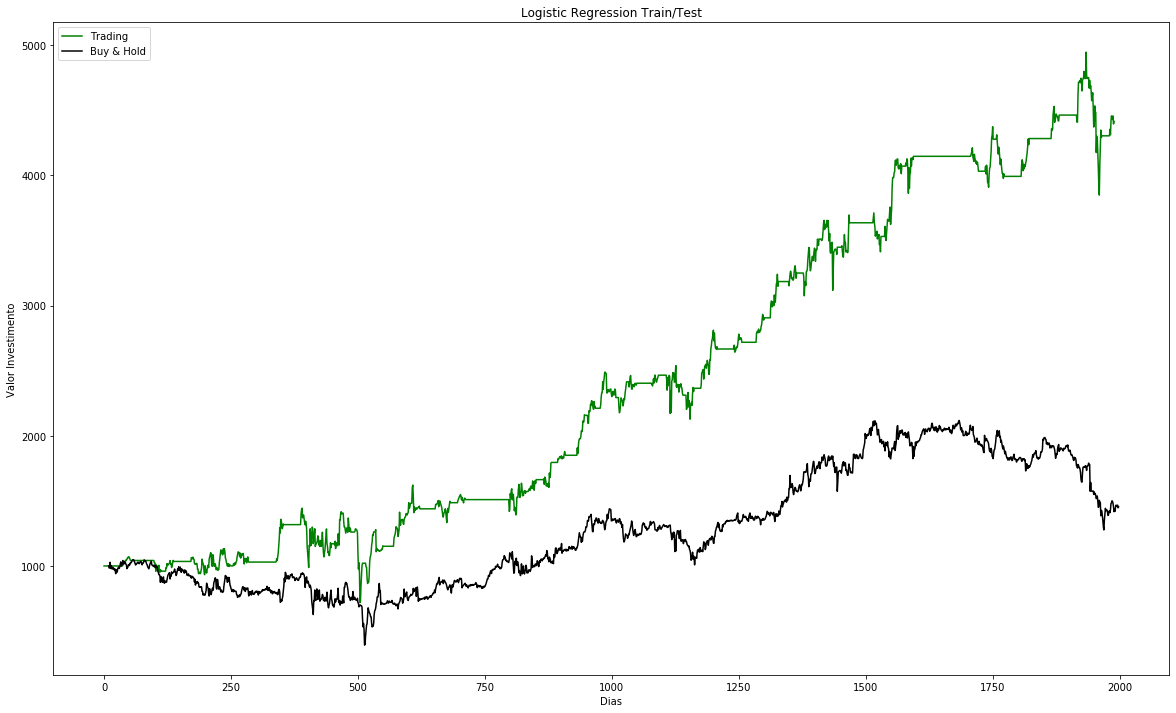

In [228]:
fig  = plt.figure(figsize=(20,12))
plt.plot(TradingResults,color='green',label='Trading')
plt.plot(BHResults,color='black',label='Buy & Hold')
plt.title('Logistic Regression Train/Test')
plt.xlabel('Dias')
plt.ylabel('Valor Investimento')
plt.legend();
plt.savefig('logistic-regression-train-test.png')

In [229]:
profit_bh = BHResults.iloc[-1] - BHResults.iloc[0]
profit_tr = TradingResults.iloc[-1] - TradingResults.iloc[0]

profit_bh_p = round(profit_bh / BHResults.iloc[0] * 100 , 2)
profit_tr_p = round(profit_tr / TradingResults.iloc[0] * 100 , 2)

print("Profit Buy & Hold:",profit_bh_p,'%')
print("Profit Trading:",profit_tr_p,'%')

Profit Buy & Hold: 45.31 %
Profit Trading: 341.49 %


## VALIDAÇÃO

In [230]:
#bbdc_validation = yf.download('BBDC',start='2015-02-23',end='2021-01-10')
#bbdc_validation.to_csv('bbdc-validation.csv')

bbdc_validation = pd.read_csv('bbdc-validation.csv')
bbdc_validation.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-23,23.000000,23.030001,22.780001,23.020000,12.132120,135400
1,2015-02-24,23.020000,23.040001,22.820000,23.000000,12.121583,149700
2,2015-02-25,23.110001,23.340000,22.910000,23.340000,12.300767,163100
3,2015-02-26,23.389999,23.570000,23.110001,23.530001,12.400903,264700
4,2015-02-27,23.629999,23.799999,23.400000,23.670000,12.474685,264800


In [231]:
bbdc_validation = bbdc_validation[['Close']]

### Crio as Features

In [232]:
bbdc_validation['RSI'] = ta.rsi(bbdc_validation['Close'],length=PERIODOS_RSI)
bbdc_validation['MACD_HISTOGRAM'] = ta.macd(bbdc_validation['Close'],fast=MACD_FAST,slow=MACD_SLOW,signal=MACD_SIGNAL).iloc[:,1]
bbdc_validation[['BBANDL','BBANDM','BBANDU']] = ta.bbands(bbdc_validation['Close'],length=PERIODOS_BBAND,std=2)
bbdc_validation['EMA'] = ta.ema(bbdc_validation['Close'],length=PERIODOS_EMA)
ClosePassado = bbdc_validation['Close'].shift(periods=N_ANTERIORES)
ClosePassado.dropna(axis='index',inplace=True)

bbdc_validation[f'Retorno{N_ANTERIORES}DiasPassados%'] = (bbdc_validation['Close'] - ClosePassado) / ClosePassado

bbdc_validation.dropna(axis='index',inplace=True)

### Crio o Alvo

In [233]:
ClosesFuturo = bbdc_validation['Close'].shift(periods= -N_FUTURO)
bbdc_validation[f'RetornoAlvoProx{N_FUTURO}Dias%'] = (ClosesFuturo - bbdc_validation['Close']) / bbdc_validation['Close']
bbdc_validation = bbdc_validation.dropna(axis=0)
bbdc_validation[f'RetornoAlvoBinProx{N_FUTURO}Dias'] = np.where(bbdc_validation[f'RetornoAlvoProx{N_FUTURO}Dias%'] > 0 , 1 , 0 )

bbdc_validation.drop(columns=[f'RetornoAlvoProx{N_FUTURO}Dias%'],inplace=True)

### Faço as predições

In [234]:
x_validation = bbdc_validation.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias'])
y_validation  = bbdc_validation[f'RetornoAlvoBinProx{N_FUTURO}Dias']

y_pred_validation = return_y_pred(x_validation,model_lr,cutoff)

### Verifico as métricas

In [235]:
print('LOGISTIC REGRESSION VALIDATION')
print(confusion_matrix(y_validation,y_pred_validation))
print(classification_report(y_validation,y_pred_validation))

LOGISTIC REGRESSION VALIDATION
[[699  52]
 [648  59]]
              precision    recall  f1-score   support

           0       0.52      0.93      0.67       751
           1       0.53      0.08      0.14       707

    accuracy                           0.52      1458
   macro avg       0.53      0.51      0.41      1458
weighted avg       0.53      0.52      0.41      1458



### Comparo Buy & Hold com Trading

In [236]:
aport_value = 1000.00
X = bbdc_validation.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias'])
TradingResultsValidation , ops = return_investment_trading(aport_value=aport_value,X=X,model=model_lr,cutoff=cutoff,N_FUTURO=N_FUTURO)
BHResultsValidation = return_investment_buy_and_hold(aport_value=aport_value,X=X)

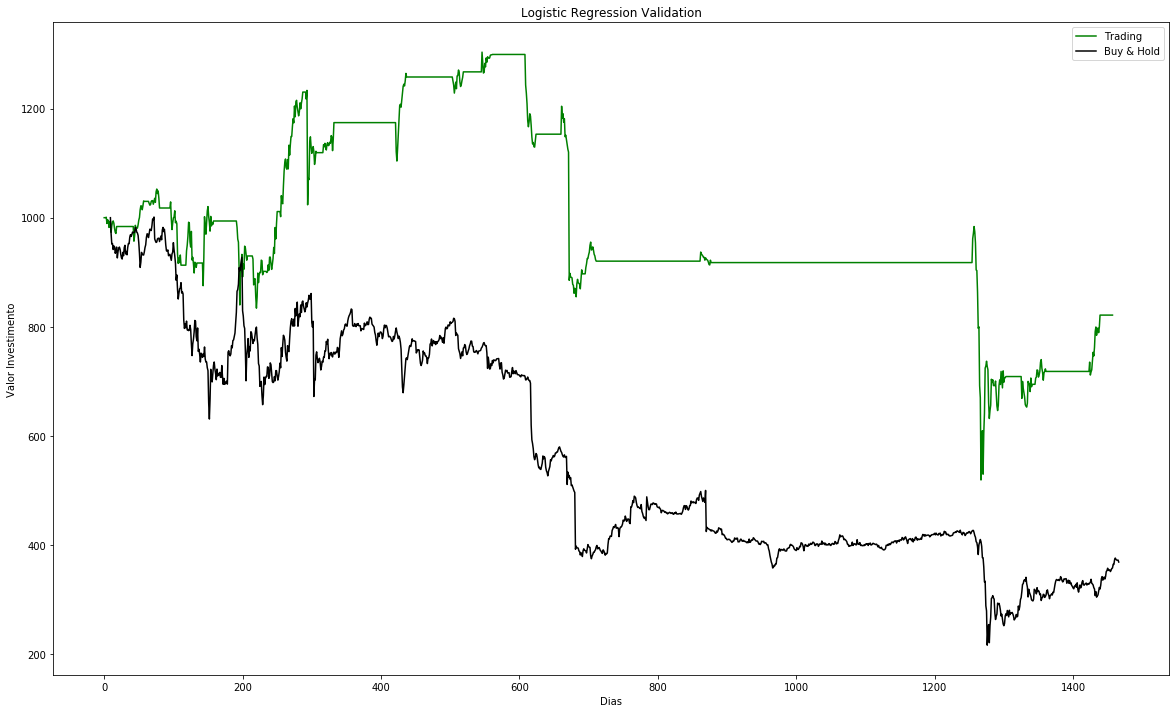

In [237]:
fig  = plt.figure(figsize=(20,12))
plt.plot(TradingResultsValidation,color='green',label='Trading')
plt.plot(BHResultsValidation,color='black',label='Buy & Hold')
plt.title('Logistic Regression Validation')
plt.xlabel('Dias')
plt.ylabel('Valor Investimento')
plt.legend();
plt.savefig('logistic-regression-validation.png')

In [238]:
profit_bh = BHResultsValidation.iloc[-1] - BHResultsValidation.iloc[0]
profit_tr = TradingResultsValidation.iloc[-1] - TradingResultsValidation.iloc[0]

profit_bh_p = round(profit_bh / BHResultsValidation.iloc[0] * 100 , 2)
profit_tr_p = round(profit_tr / TradingResultsValidation.iloc[0] * 100 , 2)

print("Profit Buy & Hold:",profit_bh_p,'%')
print("Profit Trading:",profit_tr_p,'%')

Profit Buy & Hold: -63.13 %
Profit Trading: -17.86 %
